<a href="https://colab.research.google.com/github/DrSubbiah/1.Bayesian-Inference/blob/master/113_Interpretation_Count_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="darkblue">Binary Data Model

In [ ]:
import numpy as np
import pandas as pd
import statistics as stat
import scipy
import pystan

In [ ]:
#For plots
import arviz as az
import matplotlib.pyplot as plt

#<font color="darkblue"> Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Data Sets/Churn.csv"
custcarecal_da = pd.read_csv(path)

In [ ]:
custcarecal_da

In [ ]:
custcarecal_da.columns

Index(['State', 'AccountLength', 'AreaCode', 'Phone', 'IntlPlan', 'VMailPlan',
       'VMailMessage', 'DayMins', 'DayCalls', 'DayCharge', 'EveMins',
       'EveCalls', 'EveCharge', 'NightMins', 'NightCalls', 'NightCharge',
       'IntlMins', 'IntlCalls', 'IntlCharge', 'CustServCalls', 'Churn',
       'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')

# <font color="darkblue"> Quantity of Interest QoI

- In this data set, QoI is *CustServCalls*, number of calls made by a customer

- A count variable whose range may be $[0,\infty)$

- Interest is to **estimate** the mean number of calls made by the customer population from the **sample** data

- This may be done without any predictors as a step to summarize the behaviour of QoI

- However, an explantory model may validate any question / uncertainty about the QoI and associations (if any) with predictors

- As usual, it is better to know the nature of the variable to make appropriate summary measures and modeling procedures

In [ ]:
val_QoI=custcarecal_da.CustServCalls.unique()
val_QoI.sort()
print(val_QoI)

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
custcarecal_da.CustServCalls.value_counts()

1    1181
2     759
0     697
3     429
4     166
5      66
6      22
7       9
9       2
8       2
Name: CustServCalls, dtype: int64

# <font color="darkblue"> Bayesian Model

$$Y \sim \mathrm{Poisson}(\theta)$$

$$\theta \sim \mathrm{Gamma}(a,b)$$

## <font color="darkred">**About STAN convention**

PDF of Gamma distribution is (Relating $\theta$)

$$p(\theta)=\frac{b^a}{\Gamma(a)}\theta^{a-1}e^{-b\theta}$$ where $\theta>0$ and $a,b>0$

- Mean $=\frac{a}{b}$

- Variance $=\frac{a}{b^2}$

## <font color="darkgreen"> About Prior Parameters

If we want to assign a uniform distribution on $\theta$ then $a=1,b\rightarrow 0$. This leads to an **Improper Prior**; parameter is Uniform in an unbounded interval

Informally, $$\theta \sim \mathrm{Uniform}(0,\infty)$$

Recall, PDF of Continuous Uniform distribution is

$$f(x)=\frac{1}{H-L}$$ where $L<x<H$

## <font color="darkred">**About scipy.gamma convention**

To generate few Gamma distributions to visually understand the shape of prior choices

[Gamma_Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)

$$p(\theta)=\frac{1}{\Gamma(a)s^a}\theta^{a-1}e^{-\frac{\theta}{s}}$$ where $\theta>0$ and $a,s=\frac{1}{\beta}>0$

- gamma.pdf(x, a, loc, scale)

- scale $(s)=\frac{1}{\beta}$

- Mean $=a*\mathrm{scale}$

- Variance $=a*\mathrm{scale}^2$

## <font color="darkgreen"> Prior Parameters - Using Informed Guess

We assume a prior mean as 2 with variance 10 then using the above formula it is possible to find values for a and b

**STAN convention**

$$\frac{a}{b}=2$$

$$\frac{a}{b^2}=10$$

Second relation yields

$$\frac{a}{b}\frac{1}{b}=10$$

$$\implies 2\frac{1}{b}=10$$

$$\implies b=0.2$$ and hence, from the first relation

$$a=0.4$$


**Scipy convention**

$$a=0.4, s=5$$


In [ ]:
from scipy.stats import gamma
G1=gamma.rvs(a=0.4, loc=0, scale=5,size=1000)
np.mean(G1)

1.9873089091434017

In [ ]:
fig,ax = plt.subplots(1,1)
ax.hist(G1)
plt.show()

In [ ]:
custcarecal_code1 = """
data {
    real<lower=0> a;
    real<lower=0> b;
    int<lower=0> k;
    int y[k];
}

parameters {
    real<lower=0> theta;
}


model {
      y ~ poisson(theta);
      theta ~ gamma(a, b);
}
"""
# posterior
posterior1 = pystan.StanModel(model_code=custcarecal_code1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2e8ffcea51cbb9b36bdb27ee8788cd9d NOW.


In [ ]:
n=len(custcarecal_da)
custcarecal_data = {
             'k':n,
             'y':custcarecal_da['CustServCalls'],
             'a':0.4,
             'b':0.2,
            }
print(custcarecal_data)

In [ ]:
fit_model1= posterior1.sampling(data=custcarecal_data,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

#<font color="darkorange"> MCMC convergence Diagnostics - Plots

In [ ]:
az.plot_trace(fit_model1, compact=False,legend=True)
plt.show()

# <font color="darkorange"> Condensed Summary Report

In [ ]:
summ_mod1=az.summary(fit_model1,round_to=3,hdi_prob=0.95)
summ_mod1

# <font color="darkblue"> Model 2: Uniform prior on $\theta$

In [ ]:
custcarecal_code2 = """
data {
    real<lower=0> L;
    real<lower=0> H;
    int<lower=0> k;
    int y[k];
}

parameters {
    real<lower=0> theta;
}


model {
      y ~ poisson(theta);
      theta ~ uniform(L, H);
}
"""
# posterior
posterior2 = pystan.StanModel(model_code=custcarecal_code2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_364b05bee5bb28c63778bd5f63d59780 NOW.


In [ ]:
n=len(custcarecal_da)
custcarecal_data2 = {
             'k':n,
             'y':custcarecal_da['CustServCalls'],
             'L':1,
             'H':10,
            }
print(custcarecal_data2)

In [ ]:
fit_model2= posterior2.sampling(data=custcarecal_data2,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

#<font color="darkorange"> MCMC convergence Diagnostics - Plots

In [ ]:
az.plot_trace(fit_model2, compact=False,legend=True)
plt.show()

# <font color="darkorange"> Condensed Summary Report

In [ ]:
summ_mod2=az.summary(fit_model2,round_to=3,hdi_prob=0.95)
summ_mod2

#<font color="darkblue"> Poisson GLM with One Binary Predictor

*IntlPlan* is a binary variable - whether the customer has opted for Internationla plan - Binary levels - *yes or no*

Let us prepare the data for the model

In [ ]:
custcarecal_da=custcarecal_da.assign(IntlPlan_c=lambda x:x['IntlPlan'].apply(lambda y: 1 if y=="yes" else 0))
custcarecal_da['IntlPlan_c'] = custcarecal_da['IntlPlan_c'].astype('category')

In [ ]:
print(custcarecal_da)

NameError: ignored

In [ ]:
custcarecal_fit_code1 = """
data {
int<lower=0> N;
int<lower=0> y[N];
vector[N] x;
}

parameters {
real b0;
real b1;
}
model {
y ~ poisson_log(b0 + b1 * x);

b0 ~ normal(0,100);
b1 ~ normal(0,100);
}
"""


# Posterior
posterior_fit1 = pystan.StanModel(model_code=custcarecal_fit_code1)


In [ ]:
# Input - data and values for prior parameters a and b

n=len(custcarecal_da)
y1=custcarecal_da['CustServCalls']
x1=custcarecal_da['IntlPlan_c']

custcarecal_data1 = {'N':n,
             'y':y1,
             'x':x1,
            }
custcarecal_data1

In [ ]:
custcarecal_fit1= posterior_fit1.sampling(data=custcarecal_data1,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

# print(custcarecal_fit1.stansummary(pars=["b0"], probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4))

In [ ]:
az.plot_trace(custcarecal_fit1,compact=False, legend=True)
plt.show()

In [ ]:
summ_fit1=az.summary(custcarecal_fit1,round_to=3,hdi_prob=0.95)
summ_fit1

#<font color="darkblue"> Poisson GLM with One Numeric Predictor

*NightMins* is a binary variable - Time duration of a call by the customer during night time

In [ ]:
# Input - data and values for prior parameters a and b

n=len(custcarecal_da)
y1=custcarecal_da['CustServCalls'] #brtwt_da['gestwks']-np.mean(brtwt_da['gestwks']),
x1=custcarecal_da['NightMins']-np.mean(custcarecal_da['NightMins'])

custcarecal_data2 = {'N':n,
             'y':y1,
             'x':x1,
            }
custcarecal_data2

In [ ]:
custcarecal_fit2= posterior_fit1.sampling(data=custcarecal_data2,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

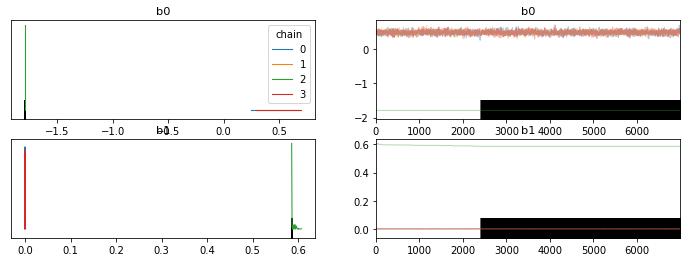

In [ ]:
az.plot_trace(custcarecal_fit2,compact=False, legend=True)
plt.show()

In [ ]:
summ_fit2=az.summary(custcarecal_fit2,round_to=3,hdi_prob=0.95)
summ_fit2

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-0.088,0.985,-1.792,0.564,0.492,0.377,6.991,4.900,1.549
b1,0.147,0.255,-0.001,0.593,0.127,0.098,6.841,11.373,1.568


In [ ]:
custcarecal_fit3= posterior_fit1.sampling(data=custcarecal_data2,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_fit3=az.summary(custcarecal_fit3,round_to=3,hdi_prob=0.95)
summ_fit3

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-0.128,1.475,-1.794,2.000,0.737,0.565,4.261,11.373,4.111
b1,0.129,0.978,-1.222,1.554,0.488,0.374,4.317,11.373,3.754


In [ ]:
custcarecal_fit_code2 = """
data {
int<lower=0> N;
int<lower=0> y[N];
vector[N] x;
real a_0;
real b_0;
real a_1;
real b_1;
}

parameters {
real b0;
real b1;
}
model {
y ~ poisson_log(b0 + b1 * x);

b0 ~ normal(a_0,b_0);
b1 ~ normal(a_1,b_1);
}
"""


# Posterior
posterior_fit2 = pystan.StanModel(model_code=custcarecal_fit_code2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eee3f48a07a58e5cf4c1018d0dedf68b NOW.


In [ ]:
# Input - data and values for prior parameters a and b

n=len(custcarecal_da)
y1=custcarecal_da['CustServCalls'] #brtwt_da['gestwks']-np.mean(brtwt_da['gestwks']),
x1=custcarecal_da['NightMins']-np.mean(custcarecal_da['NightMins'])

custcarecal_data4 = {'N':n,
             'y':y1,
             'x':x1,
             'a_0':0,
             'b_0':10,
             'a_1':1,
             'b_1':10,
            }
custcarecal_data4

In [ ]:
custcarecal_fit4= posterior_fit2.sampling(data=custcarecal_data4,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":20,"adapt_delta" : 0.99999})

# **Change Response Count to Categorical Data**

In [ ]:
conditions = [
    (custcarecal_da["CustServCalls"]==0),
    (custcarecal_da["CustServCalls"]==1),
    (custcarecal_da["CustServCalls"] > 1),]
choices = [1, 2, 3]

custcarecal_da["CustServCalls_c"] = np.select(conditions, choices)
custcarecal_da['CustServCalls_c'] = custcarecal_da['CustServCalls_c'].astype('category')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
custcarecal_da.head()